## Analysis of release date in the MCU movie data set

In [1]:
# imports

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from datetime import datetime as dt
import re

In [2]:
# load data

data_folder = './data/'
movies = pd.read_table(data_folder + 'movie.metadata.tsv', names=['wiki_id','freebase_id','name','release_date','box_office_revenue','length','language','country','genre'])
movies.shape
movies.head(1)
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wiki_id             81741 non-null  int64  
 1   freebase_id         81741 non-null  object 
 2   name                81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   length              61291 non-null  float64
 6   language            81741 non-null  object 
 7   country             81741 non-null  object 
 8   genre               81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [3]:
# extract if month and day are given
def extract_day(x):
    format = "%Y-%m-%d"
    try:
        res = bool(dt.strptime(x, format))
    except ValueError:
        res = False
    return res

def extract_month(x):
    format = "%Y-%m"
    try:
        res = bool(dt.strptime(x, format))
    except ValueError:
        res = False
    return res
# columns that indicate whether a month/ day was given in the dataset
movies['default_month'] = movies['release_date'].apply(lambda x: extract_month(str(x)))
movies['default_month_day'] = movies['release_date'].apply(lambda x: extract_day(str(x)))
print(movies.default_month.value_counts())
print(movies.default_month_day.value_counts())
movies.head(10)

False    78447
True      3294
Name: default_month, dtype: int64
False    42368
True     39373
Name: default_month_day, dtype: int64


,wiki_id,freebase_id,name,release_date,box_office_revenue,length,language,country,genre,default_month,default_month_day
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",False,True
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",False,True
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",False,False
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",False,False
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",False,False
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",False,True
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",False,False
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",False,True
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",False,False
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",False,False


In [4]:
# preparations of the data

number_nan_values = movies['release_date'].isna().sum()
print('Number of NaN values: ', number_nan_values)

# transform the string representation to date-time representation
# coerce sets invalid parsing to NaT, this applies for one date which is out of bounds
movies['release_date'] = pd.to_datetime(movies['release_date'], errors= 'coerce', utc= True)
movies['year'] = pd.DatetimeIndex(movies['release_date']).year
movies['month'] = pd.DatetimeIndex(movies['release_date']).month
movies['day'] = pd.DatetimeIndex(movies['release_date']).day
movies['release_date_ord'] = movies['release_date'].map(dt.toordinal)

movies = movies[movies['box_office_revenue'].notna()]
movies = movies[movies['release_date'].notna()]

movies.head(10)
#movies.info()


Number of NaN values:  6902


,wiki_id,freebase_id,name,release_date,box_office_revenue,length,language,country,genre,default_month,default_month_day,year,month,day,release_date_ord
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",False,True,2001.0,8.0,24.0,730721
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16 00:00:00+00:00,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",False,True,1938.0,8.0,16.0,707702
13,171005,/m/016ywb,Henry V,1989-11-08 00:00:00+00:00,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",False,True,1989.0,11.0,8.0,726414
17,77856,/m/0kcn7,Mary Poppins,1964-08-27 00:00:00+00:00,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",False,True,1964.0,8.0,27.0,717210
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01 00:00:00+00:00,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",False,True,1999.0,10.0,1.0,730028
29,156558,/m/014k4y,Baby Boy,2001-06-27 00:00:00+00:00,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",False,True,2001.0,6.0,27.0,730663
36,1364293,/m/04wy0v,They Knew What They Wanted,1940-01-01 00:00:00+00:00,932000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/0hj3nbk"": ""M...",False,False,1940.0,1.0,1.0,708205
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980-01-01 00:00:00+00:00,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",False,False,1980.0,1.0,1.0,722815
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01 00:00:00+00:00,11091868.0,103.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico"", ""/m/09c7w0"": ""United S...","{""/m/01z02hx"": ""Sports"", ""/m/07s9rl0"": ""Drama""...",False,False,2008.0,1.0,1.0,733042
54,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989-01-01 00:00:00+00:00,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",False,False,1989.0,1.0,1.0,726103


## Plots

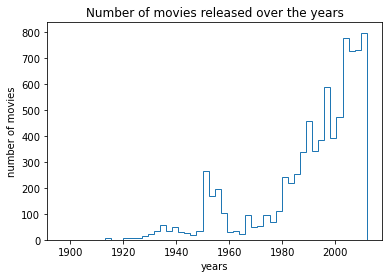

In [5]:
# plots
plt.hist(movies['year'], histtype='step', bins = 50)

plt.title("Number of movies released over the years")
plt.xlabel("years")
plt.ylabel("number of movies")
plt.show()

False    8147
True      180
Name: default_month, dtype: int64


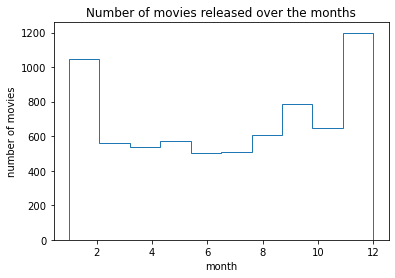

In [6]:
month_data = movies.loc[(movies['default_month'] == True) | (movies['default_month_day'] == True)]
plt.hist(month_data['month'], histtype='step', bins = 10)
print(movies['default_month'].value_counts())

plt.title("Number of movies released over the months")
plt.xlabel("month")
plt.ylabel("number of movies")
plt.show()

True     6793
False    1534
Name: default_month_day, dtype: int64


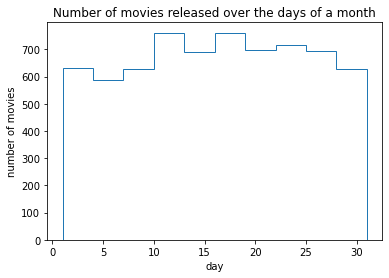

In [16]:
day_data = movies.loc[movies['default_month_day'] == True]
plt.hist(day_data['day'], histtype='step', bins = 10)
print(movies['default_month_day'].value_counts())

plt.title("Number of movies released over the days of a month")
plt.xlabel("day")
plt.ylabel("number of movies")
plt.show()

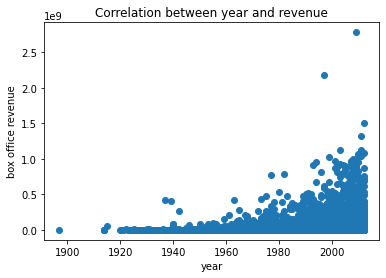

In [34]:
plt.scatter(movies['year'], movies['box_office_revenue'])

plt.title("Correlation between year and revenue")
plt.xlabel("year")
plt.ylabel("box office revenue")
plt.show()

## Statistics

In [17]:
# statistics of the release date
print(movies['release_date'].agg(['min', 'max', 'mean', 'median']))

min                1897-05-22 00:00:00+00:00
max                2012-10-25 00:00:00+00:00
mean     1991-06-28 01:00:31.559985664+00:00
median             1997-09-06 00:00:00+00:00
Name: release_date, dtype: datetime64[ns, UTC]


In [36]:
corr_pearsonr = stats.pearsonr(movies['year'],movies['box_office_revenue'])
corr_spearmanr = stats.spearmanr(movies['year'],movies['box_office_revenue'])
print('Pearson-test for Correlation between revenue and year: ', corr_pearsonr)
print(corr_spearmanr)
print('This indicates that there is a small, but significant (p < 0.05) positive correlation.')

Pearson-test for Correlation between revenue and year:  (0.18552664538795616, 2.253003816355408e-65)
SpearmanrResult(correlation=0.19602514840581106, pvalue=6.515255892123108e-73)
This indicates that there is a small, but significant (p < 0.05) positive correlation.


In [37]:
corr_pearsonr = stats.pearsonr(month_data['month'],month_data['box_office_revenue'])
corr_spearmanr = stats.spearmanr(month_data['month'],month_data['box_office_revenue'])
print('Pearson-test for Correlation between revenue and month: ', corr_pearsonr)
print(corr_spearmanr)
print('This indicates that there is a very small, but significant (p < 0.05) positive correlation.')

Pearson-test for Correlation between revenue and month:  (0.04786507135476108, 6.373881828943287e-05)
SpearmanrResult(correlation=0.06644640564618119, pvalue=2.7965872931111617e-08)


In [38]:
corr_pearsonr = stats.pearsonr(day_data['day'],day_data['box_office_revenue'])
corr_spearmanr = stats.spearmanr(day_data['day'],day_data['box_office_revenue'])
print('Pearson-test for Correlation between revenue and day: ', corr_pearsonr)
print(corr_spearmanr)
print('Since p > 0.05 we do not reject the null-hypothesis that states that there is no correlation.')

Pearson-test for Correlation between revenue and day:  (-0.010000871713586424, 0.40986152344304827)
SpearmanrResult(correlation=-0.010421258758925798, pvalue=0.3904608919585143)
Since p > 0.05 we do not reject the null-hypothesis that states that there is no correlation.


In [19]:
mod = smf.ols(formula='box_office_revenue ~ release_date_ord', data=movies)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     box_office_revenue   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     302.9
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           1.14e-66
Time:                        10:45:06   Log-Likelihood:            -1.6603e+05
No. Observations:                8327   AIC:                         3.321e+05
Df Residuals:                    8325   BIC:                         3.321e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.076e+09   1.22e+08  

In [20]:
mod = smf.ols(formula='box_office_revenue ~ month', data=month_data)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     box_office_revenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     16.01
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           6.37e-05
Time:                        10:45:07   Log-Likelihood:            -1.3966e+05
No. Observations:                6973   AIC:                         2.793e+05
Df Residuals:                    6971   BIC:                         2.793e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.422e+07   3.18e+06     13.925      0.0

In [21]:
mod = smf.ols(formula='box_office_revenue ~ day', data=day_data)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     box_office_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6793
Date:                Wed, 16 Nov 2022   Prob (F-statistic):              0.410
Time:                        10:45:07   Log-Likelihood:            -1.3614e+05
No. Observations:                6793   AIC:                         2.723e+05
Df Residuals:                    6791   BIC:                         2.723e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.901e+07   3.13e+06     18.843      0.0